# Fake News Detection Powered with BERT and Friends

- https://medium.com/@vslovik/fake-news-detection-empowered-with-bert-and-friends-20397f7e1675<br>

>- https://github.com/UKPLab/coling2018_fake-news-challenge/blob/master/data/fnc-1/corpora/FNC_ARC/combined_bodies_train.csv<br>
>- https://github.com/FakeNewsChallenge/fnc-1<br>

### BERT
BERT (Devlin et al., 2018), which stands for <b>B</b>idirectional <b>E</b>ncoder <b>R</b>epresentations from <b>T</b>ransformers, is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. BERT uses the ”masked language model” (MLM) pre-training objective, inspired by the Cloze task (Taylor, 1953). The masked language model randomly masks some of the tokens from the input, and the objective is to predict the masked word based on its context. In addition to the masked language model, BERT also uses a ”next sentence prediction” (NSP) task that jointly pre-trains text-pair representations.

For the pre-training corpus (Devlin et al., 2018) use the BooksCorpus (800M words) and English Wikipedia (2,500M words).

The self-attention mechanism in the Transformer allows BERT to model many downstream tasks — whether they involve single text or text pairs. For each task, the steps are: (1) simply plug in the task-specific inputs and outputs into
BERT and (2) fine-tune all the parameters end-to-end.

XLNet
BERT predicts all masked positions independently, meaning that during the training, it does not learn to handle dependencies between predicted masked tokens. This reduces the number of dependencies BERT learns at once, making the learning signal weaker than it could be.
Another problem with BERT is that the [MASK] token — which is at the center of training BERT — never appears when fine-tuning BERT on downstream tasks. That means that the [MASK] token is a source of train-test skew while
fine-tuning.
XLNet (Yang et al., 2019) incorporates a bidirectional context while avoiding the [MASK] tokens and independent predictions. It does this by introducing ”permutation language modeling”: instead of predicting the tokens in sequential order, it predicts tokens in some random order.
Aside from using permutation language modeling, XLNet improves upon BERT by using the Transformer XL as its base architecture.
Both BERT and XLNet can take the pair of text sequences as an input. To enable the model to distinguish between words in two different segments, BERT learns a segment embedding. In contrast, XLNet learns an embedding that represents whether two words are from the same segment. This embedding is used during attention computation between any two words.

### RoBERTa
(Liu et al., 2019) found that BERT was significantly under-trained and proposed an improved recipe for training BERT models, which they call RoBERTa (Robustly optimized BERT approach), that can match or exceed the performance of all of the post-BERT methods. The recipe includes: (1) training the model longer, with bigger batches, over more data; (2) removing the ”next sentence prediction” objective; (3) training on longer sequences; and (4) dynamically changing the masking pattern applied to the training data.

To train RoBERTa (Liu et al., 2019) use five English-language corpora of varying sizes and domains, totaling over 160GB of uncompressed text. They also demonstrate that removing the ”next sentence prediction” loss together with segment-pair input format matches or slightly improves downstream task performance.

### Fake News Detection
For our experiments on fine-tuning transformers on the FNC-1 task, we use the Simple Transformers (Rajapakse, 2019) wrapper around Hugging Face Transformers library (Wolf et al., 2019b).

The model implementations provided in the library are tested to ensure they match the original author implementations’ performances on various benchmarks. A list of architectures for which reference implementations and pre-trained weights are currently provided in Transformers includes BERT, XLNet, and RoBERTa, as well as DistilBERT, GPT and GPT2.

The Simple Transformers (Rajapakse, 2019) library is built on top of the Hugging Face Transformers. The idea behind it was to make it as simple as possible, abstracting a lot of the implementation details.
Thus, with Simple Transformers on the shoulders of Hugging Face Transformers, we could access pre-trained BERT, XLNet, and RoBERTa in a unified way without a lot of pre-processing coding.

Let us first prepare the data to feed into transformers:

In [2]:
!pip install simpletransformers==0.63.3
!pip install wandb

In [3]:
!nvidia-smi

Sun Jan 16 09:29:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import csv
import pandas as pd
from tqdm import tqdm
import wandb
import logging

from sklearn.model_selection import train_test_split

def fnc(path_headlines, path_bodies):

    map = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}

    with open(path_bodies, encoding='utf_8') as fb:  # Body ID,articleBody
        body_dict = {}
        lines_b = csv.reader(fb)
        for i, line in enumerate(tqdm(list(lines_b), ncols=80, leave=False)):
            if i > 0:
                body_id = int(line[0].strip())
                body_dict[body_id] = line[1]

    with open(path_headlines, encoding='utf_8') as fh: # Headline,Body ID,Stance
        lines_h = csv.reader(fh)
        h = []
        b = []
        l = []
        for i, line in enumerate(tqdm(list(lines_h), ncols=80, leave=False)):
            if i > 0:
                body_id = int(line[1].strip())
                label = line[2].strip()
                if label in map and body_id in body_dict:
                    h.append(line[0])
                    l.append(map[line[2]])
                    b.append(body_dict[body_id])
    return h, b, l

data_dir = '/content/drive/MyDrive/lend/fnc-1'
headlines, bodies, labels = fnc(
    os.path.join(data_dir, 'MINI_train_stances.csv'),
    os.path.join(data_dir, 'MINI_train_bodies.csv')
)

list_of_tuples = list(zip(headlines, bodies, labels))
df = pd.DataFrame(list_of_tuples, columns=['text_a', 'text_b', 'labels'])
train_df, val_df = train_test_split(df)
labels_val = pd.Series(val_df['labels']).to_numpy()

headlines, bodies, labels = fnc(
    os.path.join(data_dir, 'MINI_competition_test_stances.csv'),
    os.path.join(data_dir, 'MINI_competition_test_bodies.csv')
)

list_of_tuples = list(zip(headlines, bodies, labels))
test_df = pd.DataFrame(list_of_tuples, columns=['text_a', 'text_b', 'labels'])
labels_test = pd.Series(test_df['labels']).to_numpy()

In [6]:
wandb.login(key='8bc03e3a805535fd278efa47fca6bf2ca5793823')

wandb: Currently logged in as: whyhugo (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Then we create the instance on the Transformer model with Simple Transformers and train it. The *<font>TransformerModel</font>* constructor takes two parameters: model type and model name. All available model types and model names are listed on the Simple Transformers GitHub page: https://github.com/ThilinaRajapakse/simpletransformers.

We use *<font>`bert/bert-base-uncased`<font>*, *<font>`xlnet/xlnet-base-cased`<font>*, and *<font>`roberta/roberta-base`<font>* models. We set the learning rate to be 3e-5 for BERT and 1e-5 for XLNet and RoBERTa. (Use the validation set for the best hyper-parameters search.)

Let’s set maximum sequence length to be equal to 512 tokens: the maximum possible value to set given the parameters of pre-trained models, and the number of epoch to fine-tune the transformer to be 5.

In [17]:
sweep_config = {
    "method": "bayes",  # grid, random
    "metric": {"name": "train_loss", "goal": "minimize"},
    "parameters": {
        "num_train_epochs": {"values": [2, 3, 5]},
        "learning_rate": {"min": 1e-5, "max": 4e-4, "distribution": "uniform"},
        'dropout': {'values': [0.3, 0.4, 0.5]},
        "optimizer": {"values": ['AdamW', 'Adafactor']},
        #"train_batch_size": {"min": 4, 
                             #"max":12, 
                             #"distribution": "int_uniform"},
        "fc_layer_size": {'values': [128, 256, 512]}
    }
}
'''
sweep_config = {
    "method": "bayes",  # grid, random
    "metric": {"name": "train_loss", 
               "goal": "minimize"},
    "parameters": {
        "num_train_epochs": {'value': 5]},
        "learning_rate": {"min": 1e-5, 
                          "max": 4e-4,
                          "distribution": "uniform"},
        "dropout": {"min": 0.1, 
                    "max":0.5, 
                    "distribution": "uniform"},
        "optimizer": {"values": ['AdamW', 'adam']},
        "train_batch_size": {"min": 4, 
                             "max":12, 
                             "distribution": "int_uniform"},
        "fc_layer_size": {"min": 2, 
                          "max":8, 
                          "distribution": "int_uniform"},

    },
}
'''
sweep_id = wandb.sweep(sweep_config, project="Simple Sweep_fnc_roberta_0116_selftest4")
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Create sweep with ID: cdz9xd8e
Sweep URL: https://wandb.ai/whyhugo/Simple%20Sweep_fnc_roberta_0116_selftest4/sweeps/cdz9xd8e


In [18]:
from simpletransformers.model import TransformerModel
from simpletransformers.classification import ClassificationModel, ClassificationArgs

def train():
    # Initialize a new wandb run
    wandb.init()

    # Create a TransformerModel
    model = TransformerModel('roberta', 'roberta-base', num_labels=4, use_cuda=True, sweep_config=wandb.config, args={
        #'learning_rate':1e-5,
        #'num_train_epochs': 1,
        'reprocess_input_data': True,
        'overwrite_output_dir': True,
        'process_count': 10,
        #'train_batch_size': 1,
        'eval_batch_size': 1,
        'max_seq_length': 32,
        'fp16': True,
        'gradient_accumulation_steps': 1,
        'tensorboard_dir': '/content/drive/MyDrive/Colab_Notebooks/fnc/train_',
        'evaluate_during_training': True,
        'manual_seed': 4,
        'use_multiprocessing': True
    })

    # Train the model
    model.train_model(train_df, eval_df=test_df)

    # Evaluate the model
    model.eval_model(test_df)

    # Sync wandb
    wandb.join()

wandb.agent(sweep_id, train, count=2)

wandb: Agent Starting Run: mrczigl7 with config:
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0003033682451478325
wandb: 	num_train_epochs: 2
wandb: 	optimizer: Adafactor


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/2782 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_32_4_3


Run mrczigl7 errored: ValueError('Cannot combine manual `lr` and `relative_step=True` options')
wandb: ERROR Run mrczigl7 errored: ValueError('Cannot combine manual `lr` and `relative_step=True` options')
wandb: Agent Starting Run: nqrowmfi with config:
wandb: 	dropout: 0.3
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 2.3684105918663867e-05
wandb: 	num_train_epochs: 5
wandb: 	optimizer: AdamW


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/2782 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_32_4_3


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/348 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1798 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_32_4_3
wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
from simpletransformers.model import TransformerModel
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import wandb

wandb.init()
model = TransformerModel('roberta', 'roberta-base', num_labels=4, args={
    'learning_rate':1e-5,
    'num_train_epochs': 1,
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'process_count': 10,
    'train_batch_size': 1,
    'eval_batch_size': 1,
    'max_seq_length': 64,
    'fp16': True,
    'gradient_accumulation_steps': 1,
    'tensorboard_dir': '/content/drive/MyDrive/lend/fnc-1',
    'wandb_project': 'fnc_roberta_0116_test_simple'
})

model.train_model(train_df)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/37479 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/37479 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(37479, 0.43503764277540913)

BERT model fine-tuned, now we get predictions on the test set and evaluate fine-tuning results.

In [8]:
import numpy as np
_, model_outputs_test, _ = model.eval_model(test_df)

preds_test = np.argmax(model_outputs_test, axis=1)

NameError: ignored

Then we calculate averaged and class-wise F1 scores:

In [ ]:
from sklearn.metrics import f1_score

def calculate_f1_scores(y_true, y_predicted):
    f1_macro = f1_score(y_true, y_predicted, average='macro')
    f1_classwise = f1_score(y_true, y_predicted, average=None, labels=[0, 1, 2, 3])

    resultstring = "F1 macro: {:.3f}".format(f1_macro * 100) + "% \n"
    resultstring += "F1 agree: {:.3f}".format(f1_classwise[0] * 100) + "% \n"
    resultstring += "F1 disagree: {:.3f}".format(f1_classwise[1] * 100) + "% \n"
    resultstring += "F1 discuss: {:.3f}".format(f1_classwise[2] * 100) + "% \n"
    resultstring += "F1 unrelated: {:.3f}".format(f1_classwise[3] * 100) + "% \n"

    return resultstring

calculate_f1_scores(preds_test, labels_test)

'F1 macro: 61.013% \nF1 agree: 63.284% \nF1 disagree: 0.000% \nF1 discuss: 82.077% \nF1 unrelated: 98.692% \n'

After that we can calculate FNC-1 (the metric proposed by FNC-1 organizers) and print the confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt

LABELS = [0, 1, 2, 3]
labels = ['0','1','2','3']
RELATED = [0, 1, 2]

def print_confusion_matrix(cm):
    lines = ['CONFUSION MATRIX:']
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)
    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i], *row))
        lines.append("-"*line_len)
    lines.append("ACCURACY: {:.3f}".format((hit / total)*100) + "%")
    print('\n'.join(lines))

def fnc_score_cm(predicted_labels, target):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]
    for i, (g, t) in enumerate(zip(predicted_labels, target)):
            if g == t:
                score += 0.25
                if g != 3:
                    score += 0.50
            if g in RELATED and t in RELATED:
                score += 0.25

            cm[g][t] += 1
    return score,  cm

fnc_score, cm_test = fnc_score_cm(preds_test, labels_test)
print("\nRelative FNC Score: {:.3f}".format(100/13204.75*fnc_score) + "% \n")
print_confusion_matrix(cm_test)


Relative FNC Score: 75.971% 

CONFUSION MATRIX:
-------------------------------------------------------------
|           |     0     |     1     |     2     |     3     |
-------------------------------------------------------------
|     0     |   1397    |    440    |    627    |    48     |
-------------------------------------------------------------
|     1     |     1     |     0     |     0     |     0     |
-------------------------------------------------------------
|     2     |    431    |    221    |   3668    |    154    |
-------------------------------------------------------------
|     3     |    74     |    36     |    169    |   18147   |
-------------------------------------------------------------
ACCURACY: 91.339%


Let’s calculate class-wise precision and recall.

In [ ]:
from sklearn.metrics import classification_report

eval_report = classification_report(labels_test, preds_test)
print('Test report\n', eval_report)

Test report
               precision    recall  f1-score   support

           0       0.56      0.73      0.63      1903
           1       0.00      0.00      0.00       697
           2       0.82      0.82      0.82      4464
           3       0.98      0.99      0.99     18349

    accuracy                           0.91     25413
   macro avg       0.59      0.64      0.61     25413
weighted avg       0.90      0.91      0.90     25413



In [ ]:
cm = confusion_matrix(preds_test, labels_test)

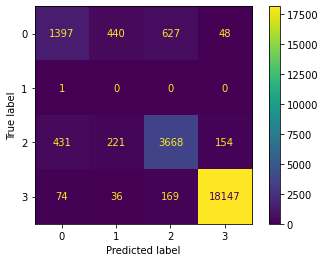

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot() 

In [ ]:
import pickle

with open('/content/drive/MyDrive/lend/train_roberta_0114.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'agree', 
                                        1: 'disagree', 
                                        2: 'disagree',
                                        3: 'unrelated'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, threshold = roc_curve(preds_test, labels_test)
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print(plt.show())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2

<Figure size 432x288 with 0 Axes>

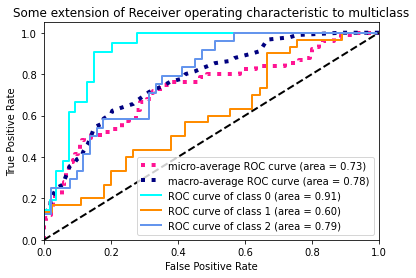

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()